Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh | bash
# This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
# from the toolbar then `Change runtime type`. You can then delete this cell.

Install needed packages

In [ ]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using ScientificTypes
using TableTransforms
using HTTP: download

### 1. Generate Random Data

Let's start by generating some random imbalanced data. Here we generate data where there are three classes `0, 1, 2` that occur with probability `0.5, 0.2, 0.3` respectively, making `0` the majority class. The data has `4` continuous features and `4` categorical features where the categorical variables have `3, 4, 2, 5` unique values respectively.

In [2]:
rng = Random.default_rng()

num_rows = 100
num_cont_feats = 4
class_probs = [0.5, 0.2, 0.3]

num_vals_per_category = [3, 4, 2, 5]

X, y = generate_imbalanced_data(num_rows, num_cont_feats; class_probs, num_vals_per_category)
X = DataFrame(X)

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.313,0.477,0.884,2.0,1.0,1.0,1.0
2,0.685,0.637,0.715,1.08,3.0,3.0,1.0,3.0
3,2.365,0.863,0.388,2.264,3.0,3.0,1.0,1.0
4,2.078,0.751,0.629,2.322,3.0,4.0,1.0,3.0
5,0.501,1.341,1.578,1.48,3.0,4.0,1.0,1.0
6,0.806,0.565,0.474,0.915,2.0,1.0,1.0,5.0
7,1.06,0.594,0.479,0.909,3.0,2.0,2.0,4.0
8,0.564,0.468,0.582,0.965,3.0,3.0,1.0,1.0
9,0.717,0.545,0.996,0.917,2.0,3.0,1.0,2.0


We follow by coercing the columns with few values (i.e., the categorical ones) to the appropriate type (a finite `sci-type` such as `OrderedFactor` or `Multiclass`). This is necessary because the `SMOTE-NC` assumes that all categorical features have `sci-type` finite.

In [3]:
X = coerce(X, autotype(X, :few_to_finite))

Row,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8
,Float64,Float64,Float64,Float64,Cat…,Cat…,Cat…,Cat…
1,1.0,0.313,0.477,0.884,2.0,1.0,1.0,1.0
2,0.685,0.637,0.715,1.08,3.0,3.0,1.0,3.0
3,2.365,0.863,0.388,2.264,3.0,3.0,1.0,1.0
4,2.078,0.751,0.629,2.322,3.0,4.0,1.0,3.0
5,0.501,1.341,1.578,1.48,3.0,4.0,1.0,1.0
6,0.806,0.565,0.474,0.915,2.0,1.0,1.0,5.0
7,1.06,0.594,0.479,0.909,3.0,2.0,2.0,4.0
8,0.564,0.468,0.582,0.965,3.0,3.0,1.0,1.0
9,0.717,0.545,0.996,0.917,2.0,3.0,1.0,2.0


### 2. Apply SMOTE-NC

#### Using Imbalance Only

Applying SMOTE-NC using the standard API is very straightforward. There are two main hyperparameters which are the number of nearest neighbors `k` and the wanted ratios of each class relative to the majority class `ratios`. In the example below, we want all three classes to have `120%` of the data that was present in the majority class (i.e., class `0` prior to applying the algorithm)

In [4]:
Xover, yover = smotenc(X, y; k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng = 42)

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01



Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  class:  1


(177×8 DataFrame
 Row │ Column1   Column2  Column3  Column4   Column5  Column6  Column7  Column ⋯
     │ Float64   Float64  Float64  Float64   Cat…     Cat…     Cat…     Cat…   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.0       0.313    0.477    0.884     2.0      1.0      1.0      1.0    ⋯
   2 │ 0.685     0.637    0.715    1.08      3.0      3.0      1.0      3.0
   3 │ 2.365     0.863    0.388    2.264     3.0      3.0      1.0      1.0
   4 │ 2.078     0.751    0.629    2.322     3.0      4.0      1.0      3.0
   5 │ 0.501     1.341    1.578    1.48      3.0      4.0      1.0      1.0    ⋯
   6 │ 0.806     0.565    0.474    0.915     2.0      1.0      1.0      5.0
   7 │ 1.06      0.594    0.479    0.909     3.0      2.0      2.0      4.0
   8 │ 0.564     0.468    0.582    0.965     3.0      3.0      1.0      1.0
  ⋮  │    ⋮         ⋮        ⋮        ⋮         ⋮        ⋮        ⋮        ⋮   ⋱
 171 │ 0.493885  1.54331  1.53232  1.1618

#### Using MLJ

To use `MLJ`, we first instantiate the model using keyword parameters, wrap it in a machine and the transform the machine with our input data `X,y`.

In [5]:
smotenc_model = Imbalance.MLJ.SMOTENC(k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.2), rng=42)
mach = machine(smotenc_model)
Xover, yover = transform(mach, X, y)

(177×8 DataFrame
 Row │ Column1   Column2  Column3  Column4   Column5  Column6  Column7  Column ⋯
     │ Float64   Float64  Float64  Float64   Cat…     Cat…     Cat…     Cat…   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1.0       0.313    0.477    0.884     2.0      1.0      1.0      1.0    ⋯
   2 │ 0.685     0.637    0.715    1.08      3.0      3.0      1.0      3.0
   3 │ 2.365     0.863    0.388    2.264     3.0      3.0      1.0      1.0
   4 │ 2.078     0.751    0.629    2.322     3.0      4.0      1.0      3.0
   5 │ 0.501     1.341    1.578    1.48      3.0      4.0      1.0      1.0    ⋯
   6 │ 0.806     0.565    0.474    0.915     2.0      1.0      1.0      5.0
   7 │ 1.06      0.594    0.479    0.909     3.0      2.0      2.0      4.0
   8 │ 0.564     0.468    0.582    0.965     3.0      3.0      1.0      1.0
  ⋮  │    ⋮         ⋮        ⋮        ⋮         ⋮        ⋮        ⋮        ⋮   ⋱
 171 │ 0.493885  1.54331  1.53232  1.1618

#### Using TableTransforms

Let's consider an example with table transforms on a more realistic dataset. This time the categorical variables are strings so all we had to do is coerce `strings`to the `multiclass` type. `smotenc` will take of encoding them and decoding them before and after applying the actual algorithm.

In [6]:
# For TableTransforms
y_ind= 3
Xy, _ = generate_imbalanced_data(num_rows, num_cont_feats; means, class_probs, insert_y=y_ind, num_vals_per_category, rng=10)
Xy = coerce(Xy, autotype(Xy, :few_to_finite))

UndefVarError: UndefVarError: means not defined

Now we instantiate the model and simply pass the data to it using the pipeline operator `\>`. This is equivalent to calling `apply` from table transforms.

In [7]:
using Imbalance: TableTransforms.SMOTENC
smote_model_t = SMOTENC(y_ind, knn_tree="Ball", ratios=Dict(1=> 1.2, 2=>1.2, 3=>1.2, 4=>1.2), rng=42)
Xyover = Xy |> smote_model_t

UndefVarError: UndefVarError: Xy not defined

### 3. Plot the Results

We can finally plot the data before and after to validate the results.

┌ Warning: Reading one byte at a time from HTTP.Stream is inefficient.
│ Use: io = BufferedInputStream(http::HTTP.Stream) instead.
│ See: https://github.com/BioJulia/BufferedStreams.jl
└ @ HTTP.Streams /Users/essam/.julia/packages/HTTP/SN7VW/src/Streams.jl:240
┌ Info: Downloading
│   source = https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl
│   dest = ./plot.jl
│   progress = NaN
│   time_taken = 0.29 s
│   time_remaining = NaN s
│   average_speed = 16.895 KiB/s
│   downloaded = 4.849 KiB
│   remaining = ∞ B
│   total = ∞ B
└ @ HTTP /Users/essam/.julia/packages/HTTP/SN7VW/src/download.jl:132


   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


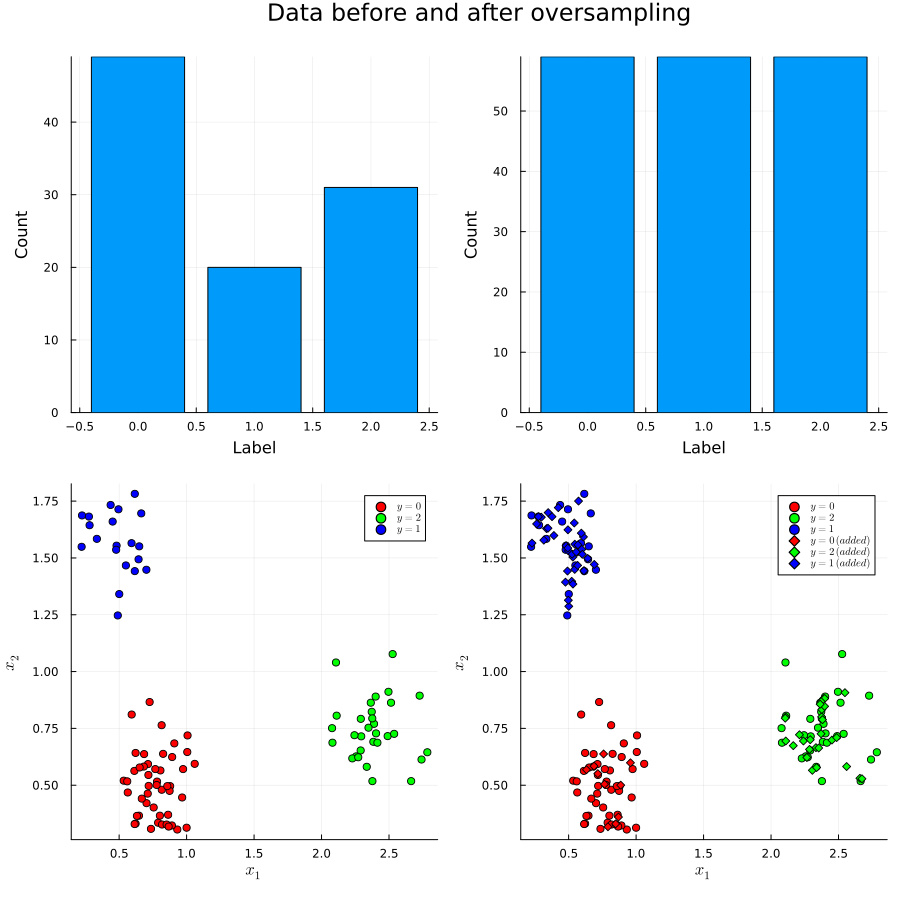

In [8]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/smotenc.gif")
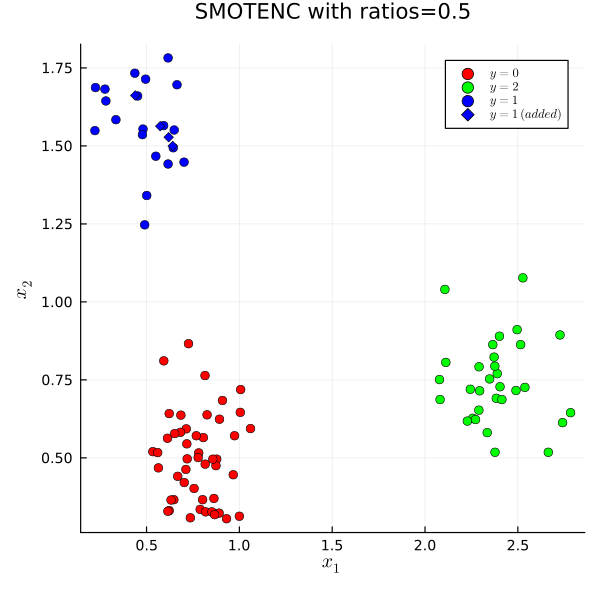

In [9]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for ratios ∈ 0.5:0.01:1.2
	X_under, y_under = smotenc(X, y; ratios = ratios, rng = Random.Xoshiro(42))
	plot_data(y, y_under, X, X_under; single_plot=true, 
			  single_plot_title="SMOTENC with ratios=$ratios")
end

gif(anim, (isdir("./assets")) ? "./assets/smotenc.gif" : "./smotenc.gif", fps=3)